<a href="https://www.kaggle.com/code/khaydaraliev97/binary-classification-with-a-bank-churn-dataset?scriptVersionId=185379605" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict

from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, RocCurveDisplay

from scipy.stats import randint
import time
import warnings
warnings.simplefilter("ignore", category=PendingDeprecationWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=UserWarning)

In [3]:
url = '/kaggle/input/playground-series-s4e1/train.csv'
df = pd.read_csv(url)
df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [5]:
df.shape

(165034, 14)

In [6]:
df.isna().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [7]:
df.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [8]:
df.drop(['id','CustomerId','Surname','Geography','Gender'],axis=1).corrwith(df['Exited']).abs().sort_values(ascending=False)

Exited             1.000000
Age                0.340768
NumOfProducts      0.214554
IsActiveMember     0.210237
Balance            0.129743
CreditScore        0.027383
HasCrCard          0.022141
Tenure             0.019565
EstimatedSalary    0.018827
dtype: float64

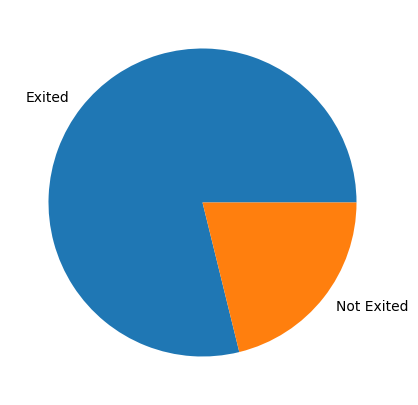

In [9]:
churn_rate = df['Exited'].value_counts()/len(df)*100
plt.figure(figsize=(5,5))
plt.pie(churn_rate, labels=['Exited','Not Exited'])
plt.show()

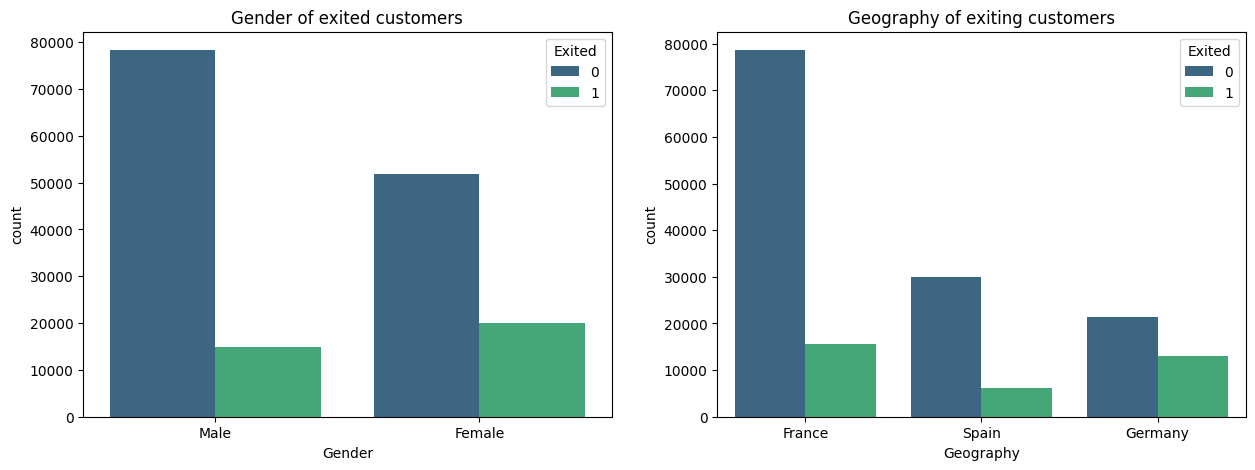

In [10]:
df1 = df.copy()
df1['Exited'] = df1['Exited'].astype(str)

fig, axes = plt.subplots(1,2, figsize=(15,5))

sns.countplot(x='Gender', hue='Exited', palette='viridis', data=df1, ax=axes[0])
axes[0].set_title("Gender of exited customers")

sns.countplot(x='Geography', hue='Exited', palette='viridis', data=df1, ax=axes[1])
axes[1].set_title("Geography of exiting customers")

plt.show()

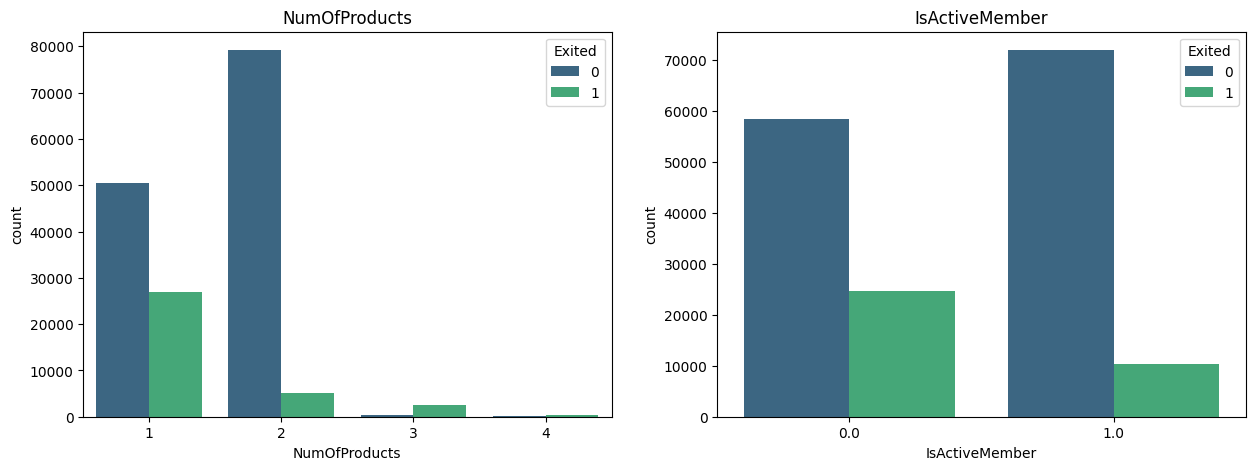

In [11]:
df1 = df.copy()
df1['Exited'] = df1['Exited'].astype(str)

fig, axes = plt.subplots(1,2, figsize=(15,5))

sns.countplot(x='NumOfProducts', hue='Exited', palette='viridis', data=df1, ax=axes[0])
axes[0].set_title("NumOfProducts")

sns.countplot(x='IsActiveMember', hue='Exited', palette='viridis', data=df1, ax=axes[1])
axes[1].set_title("IsActiveMember")

plt.show()

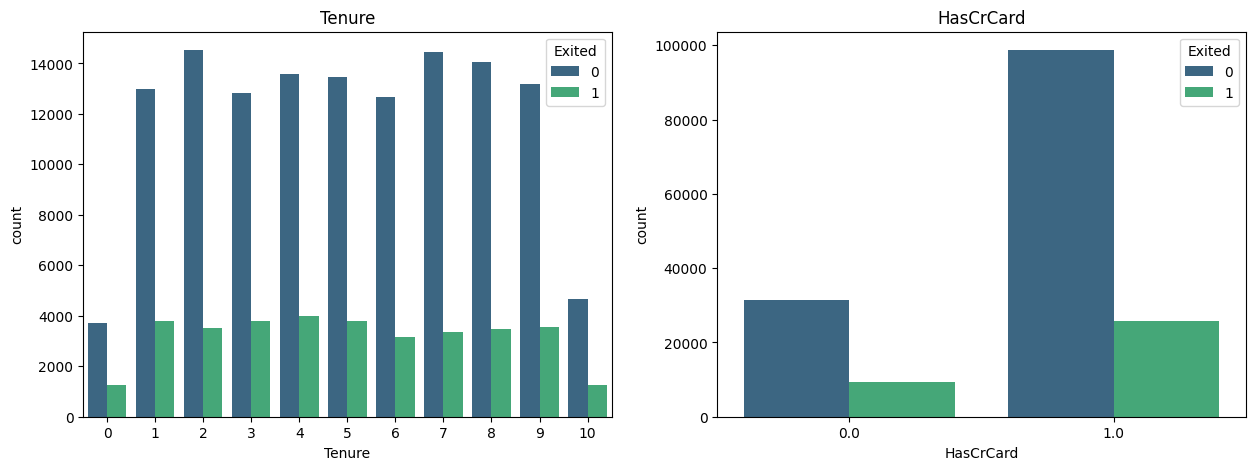

In [12]:
df1 = df.copy()
df1['Exited'] = df1['Exited'].astype(str)

fig, axes = plt.subplots(1,2, figsize=(15,5))

sns.countplot(x='Tenure', hue='Exited', palette='viridis', data=df1, ax=axes[0])
axes[0].set_title("Tenure")

sns.countplot(x='HasCrCard', hue='Exited', palette='viridis', data=df1, ax=axes[1])
axes[1].set_title("HasCrCard")

plt.show()

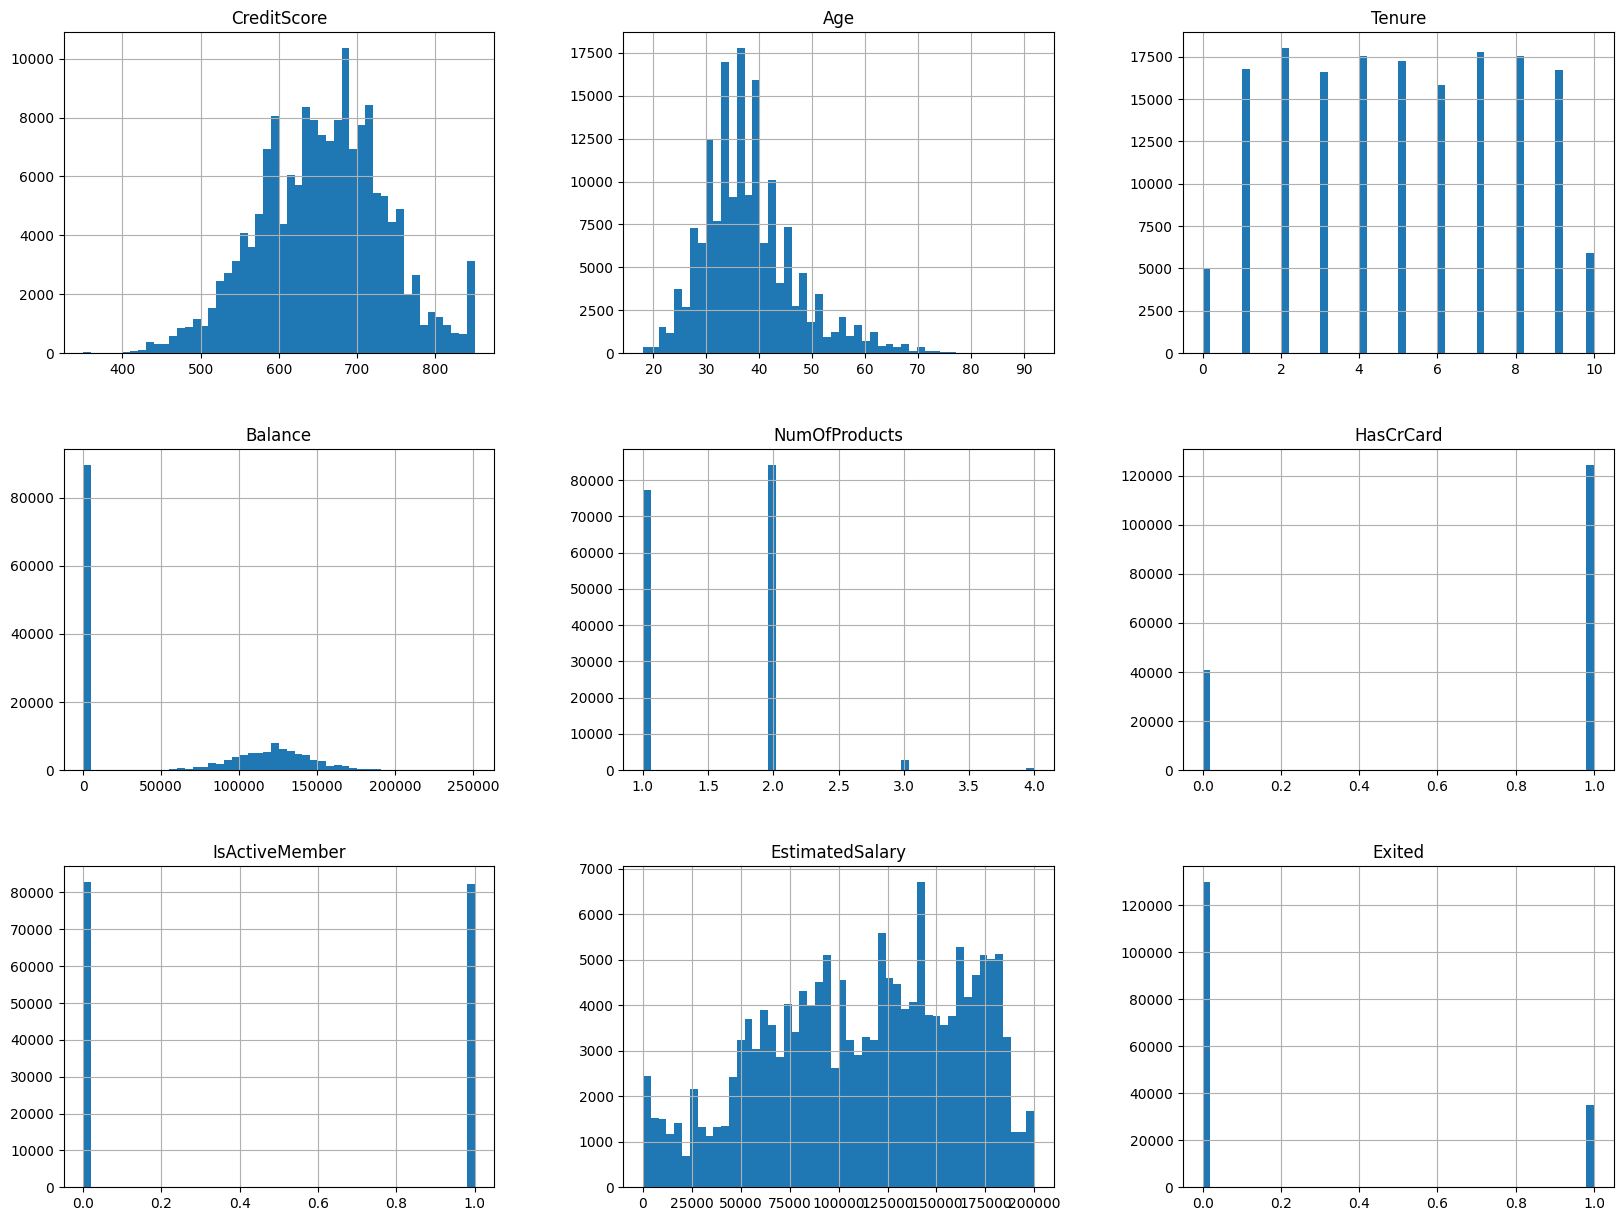

In [13]:
df_1 = df.drop(['id','CustomerId','Surname','Geography','Gender'], axis=1)
%matplotlib inline
df_1.hist(bins=50, figsize=(20,15))
plt.show()

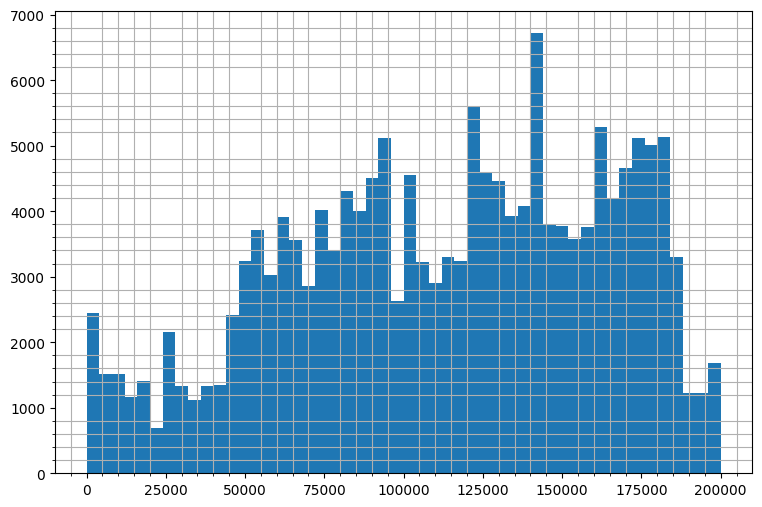

In [14]:
%matplotlib inline
df_p=df[['EstimatedSalary']]
df_p['EstimatedSalary'].hist(bins=50, figsize=(9,6))
plt.grid(which='both')
plt.minorticks_on()
plt.show()

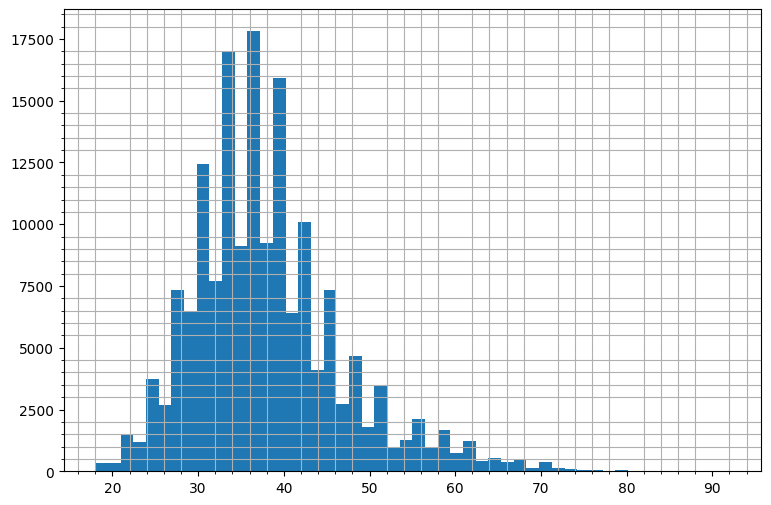

In [15]:
%matplotlib inline
df_p=df[['Age']]
df_p['Age'].hist(bins=50, figsize=(9,6))
plt.grid(which='both')
plt.minorticks_on()
plt.show()

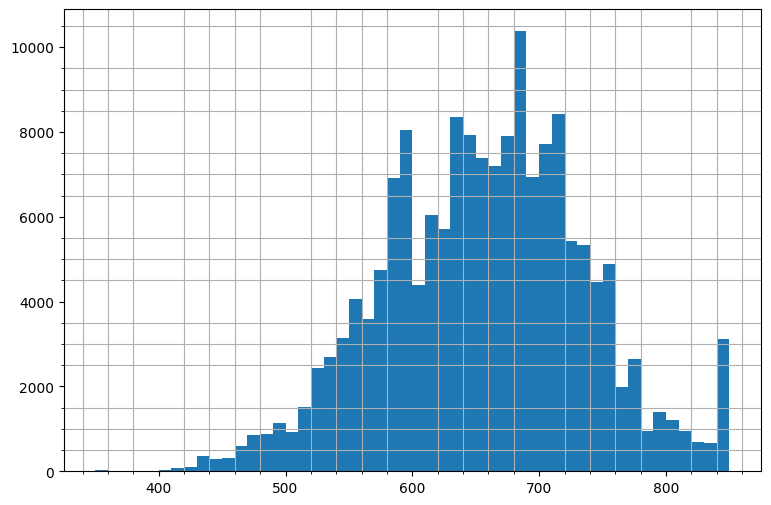

In [16]:
%matplotlib inline
df_p=df[['CreditScore']]
df_p['CreditScore'].hist(bins=50, figsize=(9,6))
plt.grid(which='both')
plt.minorticks_on()
plt.show()

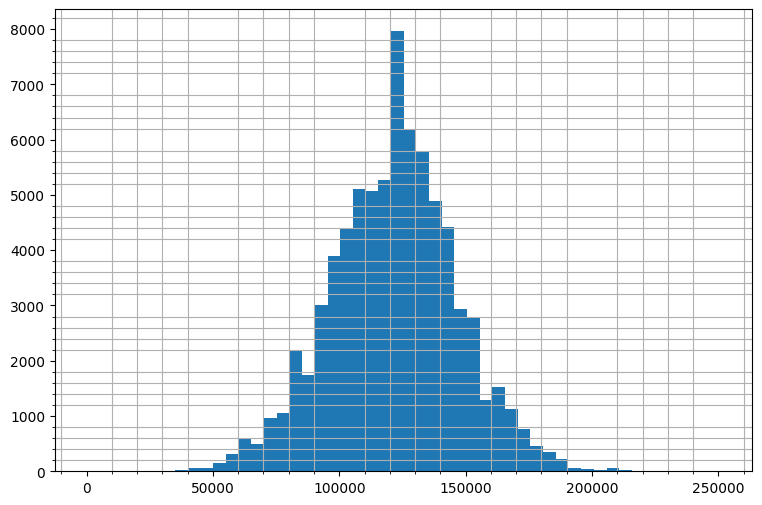

In [17]:
%matplotlib inline
df_p=df[df['Balance']>1]
df_p['Balance'].hist(bins=50, figsize=(9,6))
plt.grid(which='both')
plt.minorticks_on()
plt.show()

# **ML**

In [18]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv',index_col='id')
df_test = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv',index_col='id')

In [19]:
df_train['Exited']

id
0         0
1         0
2         0
3         0
4         0
         ..
165029    0
165030    0
165031    0
165032    0
165033    1
Name: Exited, Length: 165034, dtype: int64

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
# robust scaler

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("scaler", StandardScaler())
    ])

In [21]:
from sklearn.preprocessing import OneHotEncoder
cat_pipeline = Pipeline([
        ("cat_encoder", OneHotEncoder()),
    ])

In [22]:
from sklearn.compose import ColumnTransformer
target = ['Exited']
cat_attribs=[ 'Gender','Geography']
num_attribs=[ 'CreditScore', 'Age',
       'Tenure', 'Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary']

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

In [23]:
X = df_train.drop('Exited',axis=1)
y = df_train['Exited']

In [24]:
X_transformed = preprocess_pipeline.fit_transform(
    X[num_attribs + cat_attribs])

In [25]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X_transformed,y,test_size=0.2,random_state=42)

# **Train the RandomForestClassifier model**

              precision    recall  f1-score   support

           0       0.88      0.93      0.91     26052
           1       0.68      0.54      0.60      6955

    accuracy                           0.85     33007
   macro avg       0.78      0.74      0.75     33007
weighted avg       0.84      0.85      0.84     33007

Model aniqligi: 0.8491532099251674


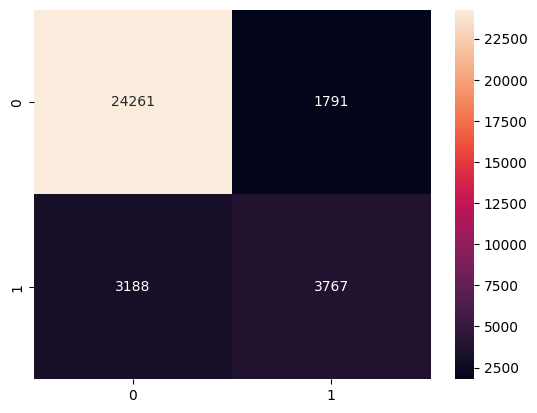

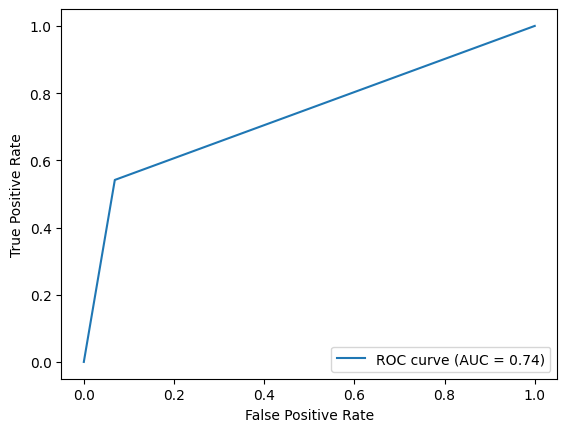

cross validation score 0.848212883282123


In [26]:
# Train the RF model
RF_model = RandomForestClassifier(n_estimators=9)
RF_model.fit(X_train, y_train)

# Modelni baholaymiz
y_pred = RF_model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Model aniqligi:", accuracy_score(y_test,y_pred))

## confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True,fmt="g")
plt.show()

## ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='ROC curve')
display.plot()
plt.show()

from sklearn.model_selection import cross_val_score
# Model evaluation using cross-validation
print(f"cross validation score {cross_val_score(RF_model, X_train, y_train, cv=5, scoring='accuracy').mean()}")

# **Train the XGBClassifier model**

              precision    recall  f1-score   support

           0       0.89      0.95      0.92     26052
           1       0.74      0.57      0.64      6955

    accuracy                           0.87     33007
   macro avg       0.81      0.76      0.78     33007
weighted avg       0.86      0.87      0.86     33007

Model aniqligi: 0.8662101978368225


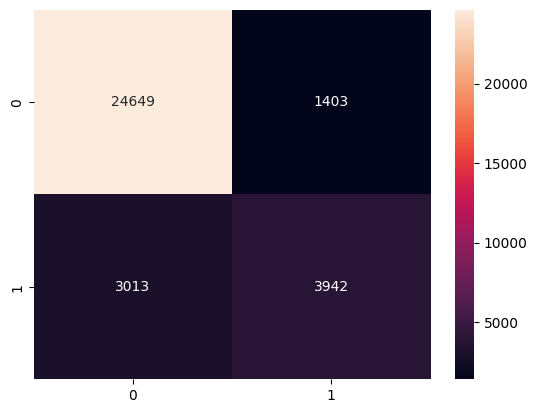

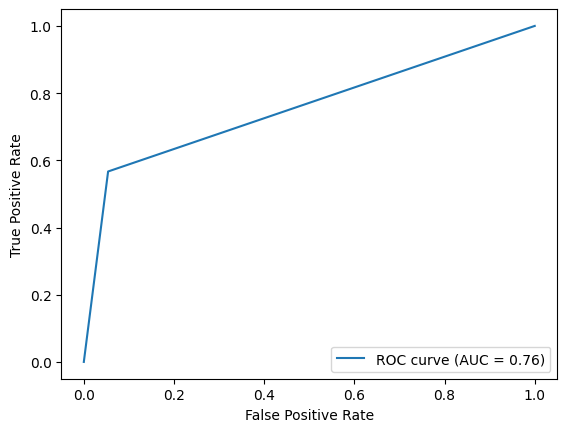

cross validation score 0.8634294670854488


In [27]:
# Modelni yaratamiz (training)
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

# Modelni baholaymiz
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Model aniqligi:", accuracy_score(y_test,y_pred))

## confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True,fmt="g")
plt.show()

## ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='ROC curve')
display.plot()
plt.show()

from sklearn.model_selection import cross_val_score
# Model evaluation using cross-validation
print(f"cross validation score {cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='accuracy').mean()}")

# **Train the KNeighborsClassifier model**

              precision    recall  f1-score   support

           0       0.88      0.93      0.91     26052
           1       0.67      0.53      0.59      6955

    accuracy                           0.85     33007
   macro avg       0.78      0.73      0.75     33007
weighted avg       0.84      0.85      0.84     33007

Model aniqligi: 0.8466688884176083


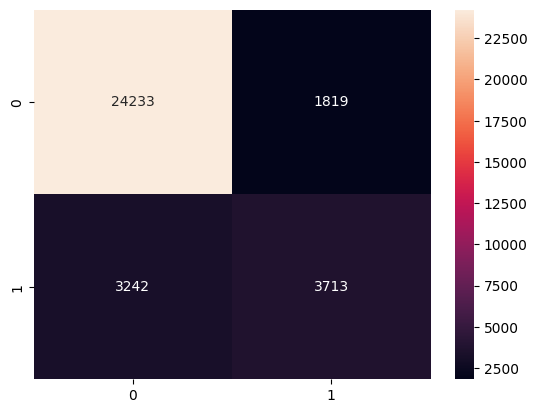

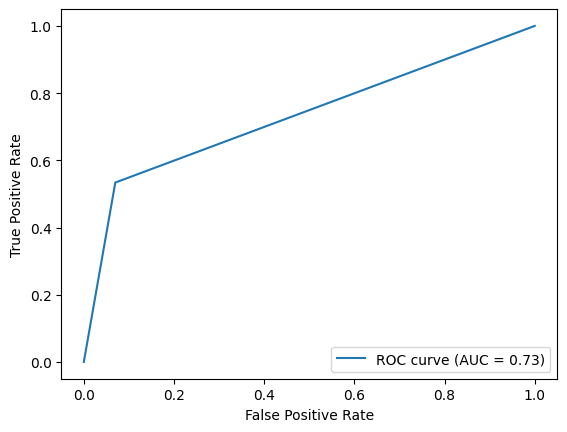

cross validation score 0.8477129745190691


In [28]:
# Train the KNN model
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

# Modelni baholaymiz
y_pred = knn_model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Model aniqligi:", accuracy_score(y_test,y_pred))

## confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True,fmt="g")
plt.show()

## ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='ROC curve')
display.plot()
plt.show()

from sklearn.model_selection import cross_val_score
# Model evaluation using cross-validation
print(f"cross validation score {cross_val_score(knn_model, X_train, y_train, cv=5, scoring='accuracy').mean()}")

# **Model evaluation & optimization**

In [29]:
from sklearn.model_selection import GridSearchCV, KFold

In [30]:
X_test_predict = preprocess_pipeline.fit_transform(
    df_test[num_attribs + cat_attribs])
X_test_predict

array([[-0.8781765 , -1.70650447, -1.06788749, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.32956726,  0.88899019, -1.06788749, ...,  1.        ,
         0.        ,  0.        ],
       [-0.00660884, -0.46518094,  0.71392236, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 0.69064529, -0.80372372, -1.06788749, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.65329239, -0.69087612, -0.71152552, ...,  1.        ,
         0.        ,  0.        ],
       [-0.44239267, -0.12663815,  0.71392236, ...,  1.        ,
         0.        ,  0.        ]])

In [31]:
Y_test_pred = xgb_model.predict(X_test_predict)
Y_test_pred

array([0, 1, 0, ..., 0, 0, 0])

In [32]:
y_result = df_test
y_result['Exited'] = Y_test_pred
y_result = y_result["Exited"]

In [33]:
y_result

id
165034    0
165035    1
165036    0
165037    0
165038    0
         ..
275052    0
275053    0
275054    0
275055    0
275056    0
Name: Exited, Length: 110023, dtype: int64

In [34]:
y_result.to_csv('subm.csv')